# General information
 * Author: Joris Busink, Junior Teacher Physics Education.
 * Date: Thu, 20th Oct.
 * About: Data processing script for high-speed camera. 

# Example: Analysis of a pendulum (SHO) using a high speed camera

## Model <a id="section_Model"></a>

In this experiment, I took data from a simple (harmonic) pendulum using a high speed camera. The data shows us the x-coordinate of the position of the mass.<br>
We can describe the x-position using Newton’s second law of motion and performing a force analysis. 

Using a force analysis we arrive to the following differential equation:

$\frac{d^2\theta}{dt^2} +\frac{g}{l}\sin{(\theta)} =0$. 

If we assume that our (initial) angle is very small we can approximate $\sin{\theta} \approx \theta$ and we arrive at

$\frac{d^2\theta}{dt^2} +\frac{g}{l} \theta =0$. 

By integrating the differential equation (twice) we arrive to the solution, which has the form:

$\theta(t) = A\sin(\omega_n t+\phi)$, &nbsp; with &nbsp; $\omega^2 =\frac{g}{l}$.<br>

Finally, in the reference frame of the camera, the equation becomes:<br>

$x(t) = A\sin(\omega t+\phi)+x_0$.

A is the amplitude of the pendulum (in the x-direction), $\omega$ is the frequency of the pendulum. 
The frequency depends on the ratio of the gravitational acceleration g and the length of the cord $l$ ($0.58 \pm 0.01$ m). <br>
$\phi$ is an arbitrary phase of the oscillation and $x_0$ is the offset.<br>


Note that we assumed $\sin{\theta}\approx\theta$, this is something that we should treat with care during the experiment. Futhermore, we assumed that we release the pendulum with with zero initial speed ($\dot{\theta}=0$), check this!

## Load packages
I load the following packages: 
* numpy; 
* matplotlib.pyplot;
* scipy.optimize
* pandas; 
<br>

We need these packages to analyze, plot and fit our data. These packages are in<br>
genereal very useful in doing numerical calculations with Python.

In [5]:
# %matplotlib widget #requires package ipympl installed, for interactive plots.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.optimize import curve_fit
np.set_printoptions(precision=4,threshold =9,suppress=True)  #Compact display of arrays.

cwd = os.getcwd() #get current working directory.
cwd= os.path.split(os.getcwd())[0] 

## Load, read and filter data from high speed camera
In this section we load, read and filter the data from the high speed camera. <br>
The output data is a .mqa extension, this is a program specific extension used by the tracking software.<br>
This extension is not a problem for Python 3 to handle.

 * Line 1: make dataframe 'df' that contains all data.<br>

 * Line 3-5: change the numerical separator from a comma to a dot (In the Netherlands we use comma for numbers, international standard is a dot.). This is optional.<br>

 * Line 6-7: remove "Not-a-Number", nan, values from the list.<br>

 * Line 9-12: make a subselection of the data. Handling large datafiles can be very slow and annoying. This is optional ofcourse. Lastly, I need to rescale my camera-data from pixels to meters.
<br>


In [6]:
df=pd.read_csv(cwd+'/data/Slingerdata_1.mqa', sep='\t',header=0)

Time = df['Time'].str.replace(',', '.').astype(float).to_list()
Xpos = df['Point #1.X'].str.replace(',', '.').astype(float).to_list()
Ypos = df['Point #1.Y'].str.replace(',', '.').astype(float).to_list()

# Time = df['Time'] #comment if data is comma delimited.
# Xpos = df['Point #1.X'] #comment if data is comma delimited.
# Ypos = df['Point #1.Y'] #comment if data is comma delimited.

Xpos = [x for x in Xpos if str(x) != 'nan']
Ypos = [x for x in Ypos if str(x) != 'nan']

scaling = 1/1010 #scaling factor from pixel to [m]
t=np.asarray(Time[:15000]) 
x = np.asarray(Xpos[0:15000])*scaling 
y = np.asarray(Ypos[0:15000])*scaling 

## Plot the data
Here I plot the raw pendulum data. On the y-axis I plot the x-position (m) of pendulum, on the x-axis I plot the time (s). <br>
I also added labels, limits and a title. These options are assumed to be self-explanatory.

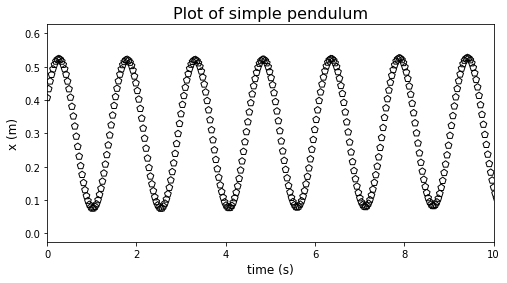

In [7]:
fig, axes = plt.subplots(1,1,figsize=(8,4)) #Creates a single figure with dimensions (8 by 4 (inch))
axes.scatter(t[::10],x[::10] ,color = 'black', s = 50, marker ='p',ec='black',fc='none') #plot every tenth datapoint t[::10], can be modified.

#plot axis labels,title and adjust limits
axes.set_title('Plot of simple pendulum',fontsize=16)
axes.set_xlabel('time (s)',fontsize=12)
axes.set_ylabel('x (m)',fontsize=12)
axes.set_xlim(0,10)
axes.set_ylim(np.min(x)-0.1,np.max(x)+0.1)

plt.show()

## Fit data to model
* Line 1-2: Here we define our model (sinus_model()) using a Python function: a function starts with <em>def</em> and ends with <em>return</em>.<br>
Sinus_model() is our user defined model based on the theory. We vary the time coordinate (the independent variable, t) and the parameters ($x_0$, A, $\omega$ and $\phi$) are determined by a fit.<br> 
Be careful that the independent variable (t) must appear<em> before </em> the parameters, otherwise an error message will appear.<br>

* Line 4: Apply a fit using the curve_fit function. [Curve_fit documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html)<br>
Curve_fit asks for a minimum of three input arguments (model, independent variable (t), dependent variable (x)), more input arguments are optional.<br> 
In our case, I provide an initial guess of the optimal parameters ($p_0$) and I provide bounds to the parameters. Other options include: weights, method, etc. <br>
Note that providing a good initial guess of $p_0$ and apply parameter bounds significantly reduces the complexity of finding the optimal parameters, if possible, provided them!<br>
<br>
The output of curve_fit are the optimal parameters <em>popt</em> and the covariance matrix $\mathcal{K_{p_i p_j}}$ <em>pcov</em>, where $\mathcal{K_{p_i p_j}}$ is defined as: <br>

&emsp;&emsp;&emsp;&emsp;&emsp; <font size="4"> $\mathcal{K_{p_i p_j}}= \begin{bmatrix} s_{p_a p_a} & s_{p_b p_a} \\ s_{p_a p_b} & s_{p_b p_b} \end{bmatrix}$.</font>  <br>

&emsp;&emsp; For example, $s_{p_a p_a}$ is the (co)variance of parameter a. To obtain the standard deviation $\sigma_{a}$ of parameter a we take the square root of the variance
$\sigma_{a} = \sqrt{s_{p_a p_a}}$. <br> 

* Line 6-8: Show the optimal values and corresponding standard deviations. <br>

* Line 10-16: Make figure, plot the data (black) and the fit (darkred).<br>

* Line 29-30: Save the figure. Note that the figure is saved as a .svg extension. A .svg extension stands for Scalable Vector Image, the image is saved as an object (and not as a collection of pixels). <br>
One can import .svg picture in e.g. inkscape, powerpoint or adobe photoshop to manipulate these.<br>

* Line 35-37: Calculation of the gravitational acceleration, the error on g is calculated using the general rules for error

The optimal value for  Offset (m) is: 0.30 ± 0.00003
The optimal value for  Amplitude (m) is: 0.22 ± 0.00005
The optimal value for  Frequency (rad/s) is: 4.12 ± 0.00002
The optimal value for  phase (rad) is: 0.48 ± 0.00043


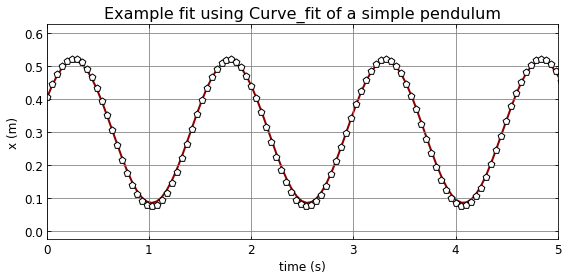

The gravitational acceleration g [$m/s^2$] =  9.84 ± 0.17


In [8]:
def sinus_model(t,x0,A,omega,phi):
    return x0+A*np.sin(omega*t+phi)

popt, pcov = curve_fit(sinus_model,t,x,p0=[0.3,0.23,4.12,0.5],bounds = ([0.1,0.2,2,0],[0.5,0.5,10,2*np.pi]))

parameter=['Offset (m)', 'Amplitude (m)', 'Frequency (rad/s)', 'phase (rad)']
for i in range (4):
    print("The optimal value for ", parameter[i], 'is:', "{:.2f}".format(popt[i]), '\u00B1', "{:.5f}".format(np.sqrt(pcov[i,i])))

xfit = np.linspace(0,max(t),1000) #create new data for fit.

#Plot data + fit        
fig,axes=plt.subplots(1,1,figsize=(8,4),sharex=True,sharey=True)
axes.plot(xfit,sinus_model(xfit,*popt), color ='darkred', lw = 2,zorder =1) #plot fit
axes.scatter(t[::15],x[::15] ,color = 'black', s = 50, marker ='p',ec='black',fc='white',zorder=2) #plot every 15th datapoint 

#plot axis labels and limits
axes.set_title('Example fit using Curve_fit of a simple pendulum',fontsize=16)
axes.set_xlabel('time (s)',fontsize=12)
axes.set_ylabel('x (m)',fontsize=12)
axes.set_xlim(0,5)
axes.set_ylim(np.min(x)-0.1,np.max(x)+0.1)

#Some plot settings
axes.tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
axes.grid(True,color='gray')
plt.tight_layout() #creates optimal padding levels for figure (especially usefull for side-by-side figures)

# location='Path' #Path to your prefered location, e.g. User/Downloads/
# plt.savefig(location+'simple_pendulum.svg') #Extension can be .png/.jpg/.etc or .svg/.pdf (Vector Image)

plt.show()

#Calculate g + error
l,omega,dl,domega=0.58,popt[2],0.01,np.sqrt(pcov[2][2])
print('The gravitational acceleration g [$m/s^2$] = ', "{:.2f}".format(omega**2*l), "\u00B1",
      "{:.2f}".format(np.sqrt((2*omega*l*domega)**2+(omega**2*dl)**2)))

### Optional: Residuals
In the previous section we fit a model to our data. We observe that the sinusoidal fit captures the data very well.<br>
However, we are also interested in the limitations of the fit. To spot these limitations can be cumbersome, to simplify our life, we calculate the difference<br>
between the data and the fit: the residuals. To visualize the residuals I will make a grid using gridspec. Using gridspec we can make two subfigures, a main figure and a sub (residuals) figure.<br>
In the main figure I plot the data and optimal fit. In the residuals plot I plot the difference of the data and the fit, <br>the residuals $\epsilon$ of the data:

<font size="4"> $\epsilon = y_{data}-y_{model}$.</font> 

The residual plot shows valuable information. For example, a systematic pattern in the residuals shows that our model cannot capture the full data.<br>
In principle, we should modify our, thereby correcting for the systematic error. 



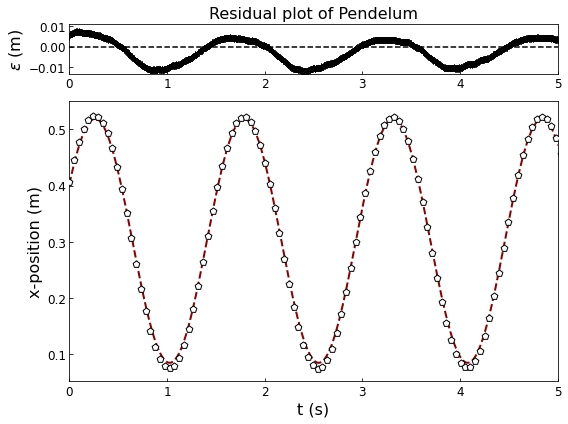

In [9]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(8,6))
gs = gridspec.GridSpec(5, 4) #Creates a grid of 6 rows and 4 columns.
axes_main = plt.subplot(gs[1:5, :4]) #Main axis goes from row 1 to 6.
axes_residuals = plt.subplot(gs[0, :4],sharex=axes_main) #Residual axis is row 0.

axes_main.tick_params(axis='both',direction ='in',labelsize=12)
axes_main.scatter(t[::15],x[::15],color='black', marker = 'p',ec='black',fc='white',s=50,zorder=3)
axes_main.plot(t,sinus_model(t,*popt),color='darkred',ls='--', lw=2)
axes_main.set_xlabel('t (s)',fontsize=16)
axes_main.set_ylabel('x-position (m)',fontsize=16)
axes_main.set_xlim(np.min(t),5)

axes_residuals.tick_params(axis='both',direction ='in',labelsize=12)
axes_residuals.set_title('Residual plot of Pendelum',fontsize=16)
axes_residuals.errorbar(t,x-sinus_model(t,*popt),xerr=0,yerr=0,fmt='none',
                        color='black',ecolor='black',capsize=3)
axes_residuals.hlines(0,np.min(t),np.max(t),color='black',ls='--')
axes_residuals.set_ylabel(r'$\epsilon$ (m)',fontsize=16)
axes_residuals.set_xlim(np.min(t),5)

plt.tight_layout()
plt.show()


## Calculate derivative (nummerical & analytical)
<p>In the previous section we plotted the data of the simple pendulum. The data looks very smooth and we can described the data (very well) by a simple pendulum model.<br>
However, in most situations, we are not interested in the position of the object, but we are interested in the velocity or (even) the acceleration of an object. <br>
If one has a (analytical) function that describes the position as a function of time, we can simply derive the velocity (or acceleration) by taking the (second) derivative with respect to time. Therefore</p> 

<font size="4"> $x(t) = A\sin(\omega_n t+\phi)+x_0$;</font><br>

<font size="4"> $v(t) = \frac{dx(t)}{dt} = \omega_n A \cos(\omega_n+\phi)$;</font><br>

<font size="4"> $a(t) = \frac{d^2x(t)}{dt^2} = -\omega_n^2 A \sin(\omega_n+\phi)$.</font><br>

<p> The velocity (v) and acceleration (a) can be approximated using the estimated parameters (previous section).<br> 

However, in most (realistic) (bio)mechanical systems, we do not have an exact model that describes our measurements. <br>
We are forced to calculate a derivative using nummerical methods. A straigthforward method to calculate the derivative of a dataset is to use the <em>Euler</em> forward, backward or central method. <br>
The Euler central method works as following:<br>

<font size="4"> $f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}$.</font><br> 

An intuitive explanation is that we approximate the derivative by evaluating the function $f(x)$ at $f(x+h)$ and $f(x-h)$, with h the stepsize.<br> 
Next, we take the difference of these expressions and divide by twice the stepsize. The smaller the stepsize we use, the better the approximation will be! <br>
Other (more advanced) methods to approximate a derivative of a function f(x) are based on higher-order derivatives. These methods are ofter more precise (or faster), but are cumbersome to implement.</p>

In Python, we can take the gradient function to calculate the derivative. It uses the Euler central method. Note that at the boundaries $t=t_0$ or $t=t_{final}$, the central method fails to work.<br> 
However, the numpy gradient function switches to Euler forward/backward method to compensate for the loss of data at the edges.

The following links can provide some more information about the used methods.<br>
* [Numpy Gradient function](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html)<br>
* [Nummerical Differentiation using Python](https://personal.math.ubc.ca/~pwalls/math-python/differentiation/differentiation/)<br>
<br>
* Line 1-2: I take the derivative of the position data with respect to time (line 1). In line 2 I take the second derivative, to obtain the acceleration.<br>
* Line 4-12: I make a figure of 1 row and 3 columns. I plot the x-t data (black pentagons) (panel 1) and model (solid line, darkred). In panel 2 and 3 I plot the velocity and acceleration versus time.<br>
* Line 14-33: Some aesthetic aspects of the plot.<br>

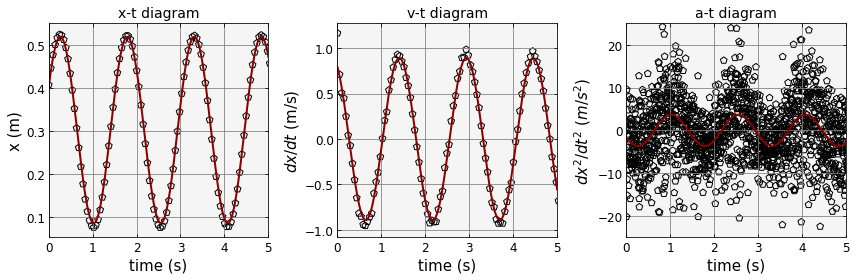

In [10]:
der1 = np.gradient(x,t)
der2 = np.gradient(der1,t)

fig,axes=plt.subplots(1,3,figsize=(12,4))
axes[0].scatter(t[::15],x[::15],color = 'black', s = 50, marker ='p',ec='black',fc='none') #plot every tenth datapoint [::10]
axes[0].plot(t,sinus_model(t,*popt),color='darkred',lw=2)

axes[1].scatter(t[::15], der1[::15], color='black', s = 50, marker ='p',ec='black',fc='none')
axes[1].plot(t,popt[2]*popt[1]*np.cos(popt[2]*t+popt[3]),color='darkred',lw=2)

axes[2].scatter(t[::], der2[::], color='black', s = 50, marker ='p',ec='black',fc='none')
axes[2].plot(t,-popt[2]**2*popt[1]*np.sin(popt[2]*t+popt[3]),color='darkred',lw=2)

axes[2].set_ylim(-25,25)
axes[0].set_title('x-t diagram',fontsize=14)
axes[1].set_title('v-t diagram',fontsize=14)
axes[2].set_title('a-t diagram',fontsize=14)

for i in range(3):
    axes[i].set_xlim(0,5)
    axes[i].set_xlabel('time (s)',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].set_facecolor('whitesmoke')
    axes[i].grid(True,color='gray')

axes[0].set_ylabel('x (m)',fontsize=15)
axes[1].set_ylabel(r'$dx/dt$ (m/s)',fontsize=15)
axes[2].set_ylabel(r'$dx^2/dt^2$ $(m/s^2)$',fontsize=15)
plt.tight_layout()
plt.show()

# location='user_defined_location'
# plt.savefig('location'+'simple_pendulum.svg')

## Results
In the previous figure, we observe that the x-t and v-t diagram still look reasonable. However, the a-t diagram is <em>very</em> chaotic. It is difficult to observe the expected (analytical) acceleration. <br>
Before we try to resolve this issue, we first have to understand it a bit better.<br>

The noisy data is a result of the method to calculate a derivative:<br>

<font size="4"> $f'(x) \approx \frac{f(x+h)-f(x-h)}{2h}$.<br> </font>

In our experiment, we use a high-speed camera, that produces (around) 500 fps. This means that we have a timestep of h = 1/fps = 0.002 seconds. Any observed difference in x(t) is magnified<br> 
in the calculation of the velocity by ~$h^-1$ and even by ~$h^-2$ for the acceleration. This is in principle not a problem of the method, but of the finite resolution of the camera. <br>
If we would have an even faster acquistion rate (fps) we could in principle obscure single pixel differences between frames. The downside is that, between these frames<br>
 the acceleration is $a=1$ $/h^2$ $[pixel/s^2]$. The acceleration that we obtain therefore depends on the resolution of the camera.  

In practice, we also have to deal with noise, this makes the method to calculate a derivative even more problematic.<br>
 To resolve these issues we can do the following methods: 
* Decrease resolution of temporal data;
* Apply a smoothing technique to reduce the effect of noise.

Both methods decrease the resolution of the temporal data.  In most (bio)mechanical experiments, this is not an issue.<br>

Note that these are not the only two options, more advanced filtering techniques excist e.g. spectral filtering, kernel smoothing, etc., but these are tedious to implement<br>
and beyond the scope of the practical course.

For further reading I recommend the following papers:
* [Numerical differentiation of experimental data](https://www.sciencedirect.com/science/article/pii/S0010465507003116)<br>
* [Numerical differentiation of noisy data](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7899139/)<br>


## Method 1: Change temporal resolution (easy)
In this method we decrease the temporal resolution of the data. Instead of taking the derivative between each consequtive point, we calculate the derivative of each n-th consequtive point n $\in$ {1,2,3,4}.<br> 
We therefore (effectively) smooth the data. This also implies that we could've decreased our acquisition rate by a factor n. Keep this in mind during your own experimental work!

The downside of this method, is that we throw away a lot of data that could be potentially useful. 

 * line 2: define the n-th consequtive point.
 * line 6-10: decrease the resolution of the time and position data. Calculate the new velocities and acceleration.
 * line 11-12: plot nummerical and analytical derivative of the data.


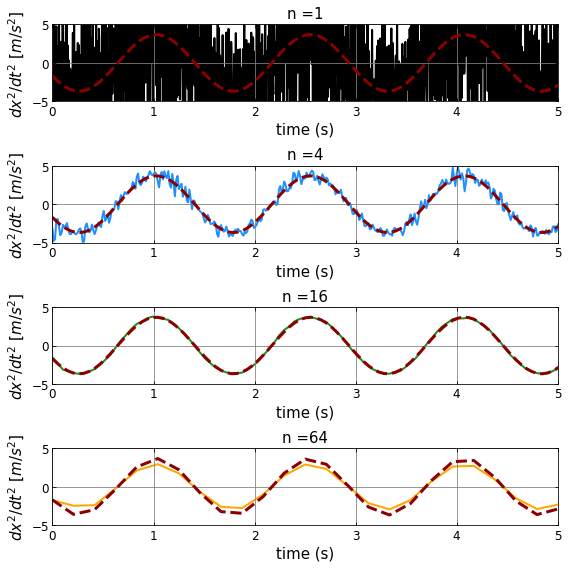

In [11]:
fig,axes=plt.subplots(4,1,figsize=(8,8))
slicelist= [1,4,16,64]
lwlist=[2,2,2,2,2]
colorlist=['black','dodgerblue','forestgreen','orange','purple']
for i in range(len(slicelist)):
    x2 = x[::slicelist[i]]
    t2 = t[::slicelist[i]]
    der_slice1 = np.gradient(x2,t2)
    der_slice2 = np.gradient(der_slice1,t2)
    
    axes[i].plot(t2,der_slice2,color = colorlist[i],lw=lwlist[i],zorder=1)
    axes[i].plot(t2,-popt[2]**2*popt[1]*np.sin(popt[2]*t2+popt[3]),color='darkred',lw=3,ls='--',zorder=2)
    
    axes[i].set_title("n =" + str(slicelist[i]),fontsize=15)
    axes[i].set_ylim(-5,5)
    axes[i].set_xlim(0,5)
    axes[i].set_xlabel('time (s)',fontsize=15)
    
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].grid(True,color='gray')
    axes[i].set_ylabel(r'$dx^2/dt^2$ $[m/s^2]$',fontsize=15)
plt.tight_layout()


## Method 2: Smoothing data (harder)
In this method we apply a smoothing technique to our data. Our starting point is the very noisy acceleration data. Instead of cropping the data, we can apply a smoothing technique: Savitzky-Golay filtering.<br> 
The “savgol” filter is often used as a preprocessing in spectroscopy and signal processing. The filter can be used to reduce high frequency noise in a signal due to its smoothing properties and reduce low frequency signal (e.g., due to offsets and slopes) using differentiation [1]. 

**The Savitzky-Golay (savgol) Filter:**  <br>
For a given signal measured at N points and a filter of window width, w, savgol calculates a polynomial fit of order o in each filter window as the filter is moved across the signal [1].<br>
The result of this operation is a smoothened curve of the data. The downside is, just like the previous method, that the high-frequency components of the data are removed,<br> 
i.e. a decrease in the resolution of the data [2].

* [[1] Savitzky-Golay Smoothing and Differentiation Filter](https://eigenvector.com/wp-content/uploads/2020/01/SavitzkyGolay.pdf)<br>
* [[2] Savitzky-Golay Smoothing Filters](http://phys.uri.edu/nigh/NumRec/bookfpdf/f14-8.pdf)<br>
<br>
* line 1: import savgol_filter
* line 4: define the number of neighbours (width) of the filter. 
* line 9: apply savgol_filter, with window width defined in line 4 and a polynomial fit of order 1 (linear).

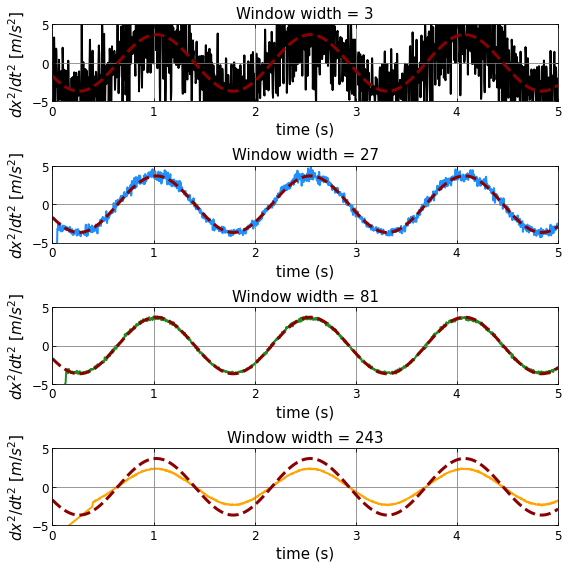

In [12]:
from scipy.signal import savgol_filter

fig,axes=plt.subplots(4,1,figsize=(8,8))
neighbourlist= [3,27,81,243]
lwlist=[2,2,2,2,2]
colorlist=['black','dodgerblue','forestgreen','orange','purple']

for i in range(len(slicelist)):    
    axes[i].plot(t, savgol_filter(der2,neighbourlist[i],1),color = colorlist[i],lw=lwlist[i],zorder=1)
    axes[i].plot(t,-popt[2]**2*popt[1]*np.sin(popt[2]*t+popt[3]),color='darkred',lw=3,ls='--',zorder=2)
    
    axes[i].set_title("Window width = " + str(neighbourlist[i]),fontsize=15)
    axes[i].set_ylim(-5,5)
    axes[i].set_xlim(0,5)
    axes[i].set_xlabel('time (s)',fontsize=15)
    axes[i].tick_params(direction="in",labelsize=12,bottom = True,top = True,left= True,right=True) #inward direction of tick-lines
    axes[i].grid(True,color='gray')
    axes[i].set_ylabel(r'$dx^2/dt^2$ $[m/s^2]$',fontsize=15)
plt.tight_layout()



## Discussion
In the previous two figures, we observe the same trend, as we increase the strength of the filtering, the nummerical acceleration $a_{obs}$ <br>
converges towards the analytical acceleration $a_{fit}$ (based on a simple pendulum). The nummerical acceleration $a_{obs}$ depends on the window width, i.e. the savgol_filter width or the concatenated data method. <br>
To find the optimal filtering window is challenging. In the last figure (of both methods) the filtering was too strong. We start to lose data. 

<div class="alert alert-block alert-warning">
Always (!) check if your filter solely removes the noise and not the signal your are looking for!
</div>

In principle we could quanitfy the deviation between the observed and expected data using the $\chi^2$ analysis: <br>

<font size="4"> $\chi^2 = \sum_{n=1}^{n=N}\frac{(a_{obs}(t)-a_{fit}(t))^2}{\sigma_{a_{obs}}^2}$. </font >

$\sigma_{a_{obs}}$ is the standard deviation 'error' on the observed acceleration. 
Lastly, we should correct for the number of <em>degrees of freedom</em>. We have N data points and c (c=1, the filter width) parameters, so we have<br>
d = N - c <em>degrees of freedom</em>. We define the following:

<font size="4"> $\tilde{\chi}^2 =\frac{\chi^2}{d}$ </font >

$\tilde{\chi}^2$ is the reduced $\chi^2$, where we included the effect of the degrees of freedom. The value of $\tilde{\chi}^2$ is a measure of the deviation<br> 
between the data and the model. This deviation is, in priniciple, a function of the window-width, and is therefore problem specific.

### Optional: Optimal Window width
In the previous cell we defined the $\tilde{\chi}^2$. In the next block I calculate the $\tilde{\chi}^2$ as a function of the window width. <br>
We observe that the optimal filtering window w = 79 neighbours. If our window width is larger than 79 neighbours we start losing data.<br>
Note that this procedure can only be applied if we know the model!

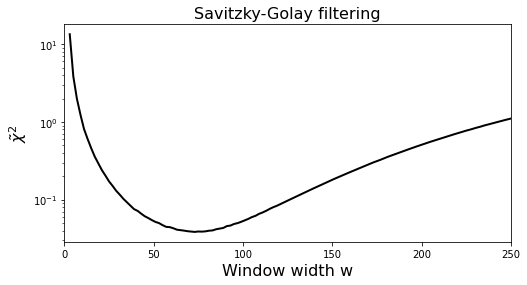

In [14]:
rchi_2_list,width_filter = [],[]
for i in range(3,281,2):
    deviation = (savgol_filter(der2[i:],i,1) + popt[2]**2*popt[1]*np.sin(popt[2]*t[i:]+popt[3]))
    rchi_2 = np.sum(deviation**2)/(len(t)-1)
    rchi_2_list.append(rchi_2)
    width_filter.append(i)


fig,axes=plt.subplots(1,1,figsize=(8,4))
axes.plot(width_filter,rchi_2_list, color = 'black', lw=2)
axes.set_title("Savitzky-Golay filtering",fontsize=16)
axes.set_ylabel(r"$\tilde{\chi}^2$" ,fontsize=16)
axes.set_xlabel(r"Window width w" ,fontsize=16)
axes.set_xlim(0,250)

axes.set_yscale('log')
plt.show()

# Your Experiment starts here

* Author: Student name
* Date: data
* About: Your experiment